<a href="https://colab.research.google.com/github/NiuwenC/google-tensorflow/blob/main/03_variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 自编码器实现

一个编码器和一个解码器

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras import backend
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.optimizers import Adam

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
import pickle

### 01 定义模型

In [ ]:

from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
import pickle
# 编码器



class Autoencoder():
  def __init__(self
        , input_dim
        , encoder_conv_filters
        , encoder_conv_kernel_size
        , encoder_conv_strides
        , decoder_conv_t_filters
        , decoder_conv_t_kernel_size
        , decoder_conv_t_strides
        , z_dim
        , use_batch_norm = False
        , use_dropout = False):
    self.name = 'autoencoder'
    self.input_dim = input_dim
    self.encoder_conv_filters = encoder_conv_filters
    self.encoder_conv_kernel_size = encoder_conv_kernel_size
    self.encoder_conv_strides = encoder_conv_strides
    self.decoder_conv_t_filters = decoder_conv_t_filters
    self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
    self.decoder_conv_t_strides = decoder_conv_t_strides
    self.z_dim = z_dim  # z_dim 是指最后来代表低纬度

    self.use_batch_norm = use_batch_norm
    self.use_dropout = use_dropout

    self.n_layers_encoder = len(encoder_conv_filters)
    self.n_layers_decoder = len(decoder_conv_t_filters)

    self._build()
  
  def _build(self):
    ### Encoder
    encoder_input = Input(shape=self.input_dim,name='encoder_input') # T1: 定义encoder的输入  image
    x= encoder_input
    for i in range(self.n_layers_encoder):
      conv_layer = Conv2D(filters=self.encoder_conv_filters[i],kernel_size=self.encoder_conv_kernel_size[i],
              strides=self.encoder_conv_strides[i],padding='same',
              name='encoder_conv_'+str(i))
      x = conv_layer(x)  # T2: 卷积层
      x = LeakyReLU()(x) # 激活层

      if self.use_batch_norm:
        x = BatchNormalization()(x)

      if self.use_dropout:
        x = Dropout(rate = 0.25)(x)
    
    shape_before_flattening = backend.int_shape(x)[1:] # TODO: 返回变量x的shape,第二维开始
    x= Flatten()(x)

    encoder_output = Dense(self.z_dim,name='encoder_output')(x) # Dense layer that connects this vector to the 2D latent space
    self.encoder = Model(encoder_input,encoder_output)


    ### Decoder
    decoder_input = Input(shape=(self.z_dim,),name='decoder_input')
    
    print ("shape:>>> ",np.prod(shape_before_flattening),shape_before_flattening)
    x=Dense(np.prod(shape_before_flattening))(decoder_input)  # 返回给定轴上的数组元素的乘积
    x=Reshape(shape_before_flattening)(x)

    for i in range(self.n_layers_decoder):
      conv_t_layer = Conv2DTranspose(filters=self.decoder_conv_t_filters[i],kernel_size=self.decoder_conv_t_kernel_size[i],strides=self.decoder_conv_t_strides[i],padding='same',
                                     name='decoder_conv_t_'+str(i))
      x=conv_t_layer(x)

      if i<self.n_layers_decoder-1:
        x = LeakyReLU()(x)
        if self.use_batch_norm:
          x = BatchNormalization()(x)                
        if self.use_dropout:
          x = Dropout(rate = 0.25)(x)

      else:
        x= Activation('sigmoid')(x)
    
    decoder_output= x

    self.decoder= Model(decoder_input,decoder_output)

    ### THE FULL AUTOENCODER
    model_input = encoder_input
    model_output = self.decoder(encoder_output)

    self.model = Model(model_input,model_output)

  
  def compile(self, learning_rate):
    self.learning_rate = learning_rate

    optimizer = Adam(lr=learning_rate)
    def r_loss(y_true, y_pred):
      return backend.mean(backend.square(y_true - y_pred),axis=[1,2,3])
    
    self.model.compile(optimizer=optimizer,loss = r_loss)
  
  def train(self,x_train,batch_size,epochs,run_folder,print_event_n_batches=100,initial_epoch=0,lr_decay=1):
    custom_callback = CustomCallback(run_folder,print_event_n_batches,initial_epoch,self)
    lr_sched = step_decay_schedule(initial_lr=self.learning_rate,decay_factor=lr_decay,step_size=1)

    checkpoint2 = ModelCheckpoint(os.path.join(run_folder,'weights/weights.h5'),save_weights_only=True,verbose=1)
    callbacks_list = [checkpoint2,custom_callback,lr_sched]

    self.model.fit(
        x=x_train,
        y=x_train,
        batch_size=batch_size,
        shuffle=True,
        epochs = epochs,
        initial_epoch = initial_epoch,
        callbacks = callbacks_list
    )
  

  def save(self, folder):
    if not os.path.exists(folder):
      os.makedirs(folder)
      os.makedirs(os.path.join(folder, 'viz'))
      os.makedirs(os.path.join(folder, 'weights'))
      os.makedirs(os.path.join(folder, 'images'))

    with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
      pickle.dump([
            self.input_dim
            , self.encoder_conv_filters
            , self.encoder_conv_kernel_size
            , self.encoder_conv_strides
            , self.decoder_conv_t_filters
            , self.decoder_conv_t_kernel_size
            , self.decoder_conv_t_strides
            , self.z_dim
            , self.use_batch_norm
            , self.use_dropout
            ], f)

    self.plot_model(folder)

    


  def load_weights(self, filepath):
    self.model.load_weights(filepath)  
  

  def plot_model(self, run_folder):
    plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
    plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
    plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)







### 02 定义回调函数

In [ ]:
from keras.callbacks import Callback,LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt
import os

class CustomCallback(Callback):
  def __init__(self,run_folder,print_eveny_n_batches,initial_epoch,vae):
    self.epoch = initial_epoch
    self.run_folder = run_folder
    self.print_eveny_n_batches = print_eveny_n_batches
    self.vae = vae
  
  def on_batch_end(self,batch,logs={}):
    if batch % self.print_eveny_n_batches ==0:
      z_new = np.random.normal(size=(1,self.vae.z_dim))
      reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()

      filepath = os.path.join(self.run_folder,'images','img_'+str(self.epoch).zfill(3)+'_'+str(batch)+'.jpg')
      if len(reconst.shape) == 2:
        plt.imsave(filepath,reconst,cmap='gray_r')
      else:
        plt.imsave(filepath,reconst)
  
  def on_epoch_begin(self,epoch,logs={}):
    self.epoch  +=1 


def step_decay_schedule(initial_lr,decay_factor=0.5,step_size=1):
  def schedule(epoch):
    new_lr = initial_lr *(decay_factor ** np.floor(epoch / step_size))
    return new_lr
  
  return LearningRateScheduler(schedule)

### 03 模型结构预览

In [ ]:
AE = Autoencoder(input_dim=(28,28,1),encoder_conv_filters=[32,64,64,64],encoder_conv_kernel_size=[3,3,3,3],encoder_conv_strides=[1,2,2,1]
                 ,decoder_conv_t_filters=[64,64,32,1],decoder_conv_t_kernel_size=[3,3,3,3],decoder_conv_t_strides=[1,2,2,1]
                 ,z_dim=2)
AE.model.summary()

shape:>>>  3136 (7, 7, 64)
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (No

In [ ]:
AE.encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0     

In [ ]:
AE.decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_1 (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 64)        0   

## 模型中提到的函数等详解

### 01 回调函数

回调可以传递给keras方法，如fit、evaluate和predict，以便与模型训练和推理生命周期的各个阶段挂钩.

要创建一个自定义回调，可以创建keras.callback .callback的子类并覆盖与感兴趣的阶段相关联的方法。



```
training_finished = False
class MyCallback(tf.keras.callbacks.Callback):
  def on_train_end(self, logs=None):
    global training_finished
    training_finished = True
model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(1,))])
model.compile(loss='mean_squared_error')
model.fit(tf.constant([[1.0]]), tf.constant([[1.0]]),
          callbacks=[MyCallback()])
assert training_finished == True
```
model.fit(..,callbacks=[callbacks_list])

那么具体的调用是什么时候，训练结束时吗？ 由具体定义的方法来决定，比如 on_batch_begin,on_batch_end 就是当整个batch训练完成后调用； on_epochs_begin,on_epochs_end 就是当完成一次epochs后调用.


回调函数以字典logs为参数，该字典包含了一系列与当前batch或epoch相关的信息。
* 在每个epoch的结尾处（on_epoch_end），logs将包含训练的正确率和误差，acc和loss，如果指定了验证集，还会包含验证集正确率和误差val_acc)和val_loss，val_acc还额外需要在.compile中启用metrics=['accuracy']。

* 在每个batch的开始处（on_batch_begin）：logs包含size，即当前batch的样本数

* 在每个batch的结尾处（on_batch_end）：logs包含loss，若启用accuracy则还包含acc


In [ ]:
# 从logs中获取loss损失，通过callback中的logs的loss值来决定提前终止训练
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss')<0.4):
      print("\nReached 60% accuracy so cancelling training!")
      self.model.stop_training = True


### 02 ModelCheckpoint
也是callback的一种，不过不是自动添加到训练中，需要手动添加



```
ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

```

该回调函数将在每个epoch后保存模型到filepath

filepath可以是格式化的字符串，里面的占位符将会被epoch值和传入on_epoch_end的logs关键字所填入。

save_weights_only：若设置为True，则只保存模型权重，否则将保存整个模型（包括模型结构，配置信息等）

period：CheckPoint之间的间隔的epoch数



```
checkpoint2 = ModelCheckpoint(os.path.join(run_folder,'weights/weights.h5'),save_weights_only=True,verbose=1)
```



### 03 LearningRateScheduler
学习率回调函数

### 04 r_loss测试

In [ ]:
# 因为输入是两维，所以调整axis； 4维下第一维是batch_size，不参与运算
def r_loss(y_true, y_pred):
  return backend.mean(backend.square(y_true - y_pred))


In [ ]:
a= tf.constant([[1, 2, 3],[4, 5, 6]],dtype=tf.float64)
b= tf.constant([[0.5,1,2],[3,4,5]],dtype=tf.float64)
r_loss(a,b)

<tf.Tensor: shape=(), dtype=float64, numpy=0.875>

### 05 np.random.normal

正态分布中采样



```
z_new = np.random.normal(size=(1,self.vae.z_dim))
reconst = self.vae.decoder.predict(np.array(z_new))[0].squeeze()
```
np.random.normal(size=()) 定义一个采样的向量，因为需要两个点

.squeeze() 去掉最后一维



In [ ]:
z_new = np.random.normal(size=(1,2))
print(z_new)
z_new_predict = AE.decoder.predict(np.array(z_new))
z_new_predict.shape

[[0.96318254 0.73463391]]


(1, 28, 28, 1)

In [ ]:
type(z_new_predict)

numpy.ndarray

In [ ]:
z_new_predict[0].squeeze().shape

(28, 28)

In [ ]:
a = tf.random.normal(shape=(1,3,3,1)).numpy()
print(a)
a.squeeze().shape

[[[[-0.33124763]
   [-0.862502  ]
   [ 1.2654431 ]]

  [[ 1.570876  ]
   [-0.9615483 ]
   [-0.89591724]]

  [[ 0.02791108]
   [ 0.30139005]
   [-0.52780503]]]]


(3, 3)

### 06 图片的重构

即是用decoder对画在墙上的点进行预测，预测结果就是重新绘制出来的画

## 使用手写数字进行训练


### 01 数据，运行目录等准备工作

In [ ]:
from keras.datasets import mnist
def load_mnist():
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

  x_train = x_train.astype('float32') / 255.
  x_train = x_train.reshape(x_train.shape + (1,))
  x_test = x_test.astype('float32') / 255.
  x_test = x_test.reshape(x_test.shape + (1,))

  return (x_train, y_train), (x_test, y_test)

In [ ]:
# run params  /content/drive/MyDrive/google-tensorflow/generative_model/run
SECTION = 'vae'
RUN_ID = '0001'
DATA_NAME = 'digits'
RUN_FOLDER = '/content/drive/MyDrive/google-tensorflow/generative_model/run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

MODE =  'build' #'load' #

In [ ]:
(x_train, y_train), (x_test, y_test) = load_mnist()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
type(x_train)

numpy.ndarray

### 02 定义模型进行训练

In [ ]:
AE = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if MODE == 'build':
    AE.save(RUN_FOLDER)
else:
    AE.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))


### 训练

LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0

AE.compile(LEARNING_RATE)

AE.train(x_train=x_train[:1000], batch_size = BATCH_SIZE, epochs= 500 ,run_folder= RUN_FOLDER, initial_epoch=INITIAL_EPOCH)

shape:>>>  3136 (7, 7, 64)
Epoch 1/500
32/32 [==============================] - 3s 52ms/step - loss: 0.2136

Epoch 00001: saving model to /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0001_digits/weights/weights.h5
Epoch 2/500
32/32 [==============================] - 1s 20ms/step - loss: 0.0989

Epoch 00002: saving model to /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0001_digits/weights/weights.h5
Epoch 3/500
32/32 [==============================] - 1s 18ms/step - loss: 0.0703

Epoch 00003: saving model to /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0001_digits/weights/weights.h5
Epoch 4/500
32/32 [==============================] - 1s 19ms/step - loss: 0.0664

Epoch 00004: saving model to /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0001_digits/weights/weights.h5
Epoch 5/500
32/32 [==============================] - 1s 17ms/step - loss: 0.0644

Epoch 00005: saving model to /content/drive/MyDrive/google-

### 03 模型运行权重等分析

In [ ]:
def load_model(model_class, folder):
  with open(os.path.join(folder, 'params.pkl'), 'rb') as f:
    params = pickle.load(f)
  
  print(params) # 通过保存参数，进而恢复model的构造

  model = model_class(*params)

  model.load_weights(os.path.join(folder, 'weights/weights.h5')) # 构造好一个model之后，将保存的权重等赋值到model的变量上面

  return model

In [ ]:
AE = load_model(Autoencoder, RUN_FOLDER)

[(28, 28, 1), [32, 64, 64, 64], [3, 3, 3, 3], [1, 2, 2, 1], [64, 64, 32, 1], [3, 3, 3, 3], [1, 2, 2, 1], 2, False, False]
shape:>>>  3136 (7, 7, 64)


#### 01 通过decoder预测出来的结果和原结果进行对比

In [ ]:
n_to_show=10
example_idx = np.random.choice(range(len(x_test)),n_to_show)

example_images = x_test[example_idx]

z_points = AE.encoder.predict(example_images)
reconst_images = AE.decoder.predict(z_points)

print(reconst_images.shape)

fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(hspace=0.5,wspace=0.5)

for i in range(n_to_show):
  img = example_images[i].squeeze()
  ax = fig.add_subplot(2, n_to_show, i+1)
  ax.axis('off')
  ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
  ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
  img = reconst_images[i].squeeze()
  ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
  ax.axis('off')
  ax.imshow(img, cmap='gray_r')

NameError: ignored

#### 02 打点所有数据

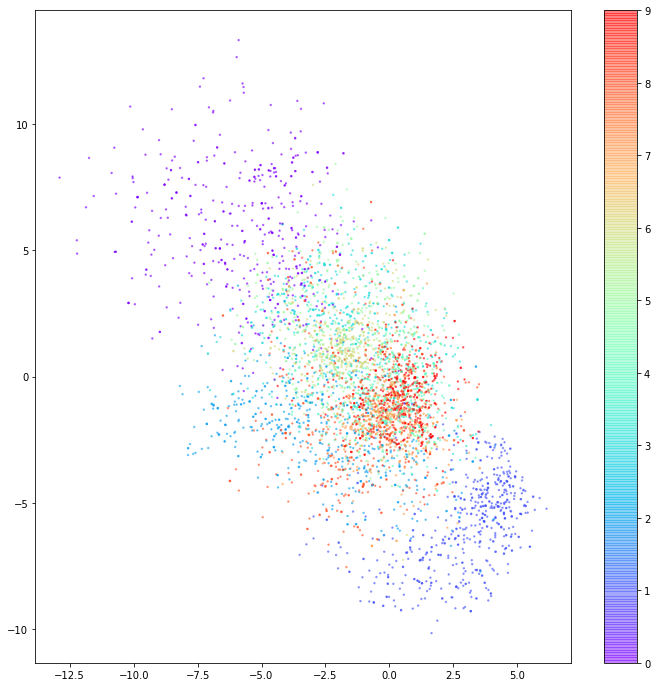

In [ ]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()

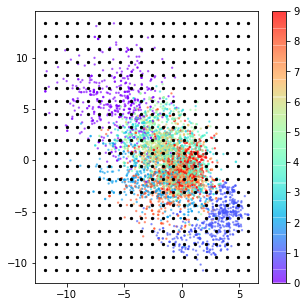

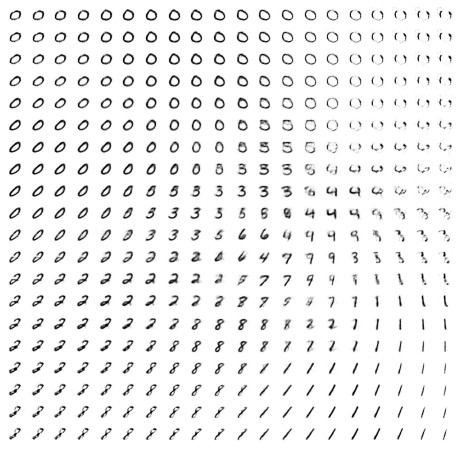

In [ ]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

## VAE 实现


### 01 结构实现


In [ ]:
from keras import backend as K

In [ ]:
class VariationalAutoencoder():
  def __init__(self
      , input_dim
      , encoder_conv_filters
      , encoder_conv_kernel_size
      , encoder_conv_strides
      , decoder_conv_t_filters
      , decoder_conv_t_kernel_size
      , decoder_conv_t_strides
      , z_dim
      , use_batch_norm = False
      , use_dropout= False
      ):
    self.name = 'variational_autoencoder'

    self.input_dim = input_dim
    self.encoder_conv_filters = encoder_conv_filters
    self.encoder_conv_kernel_size = encoder_conv_kernel_size
    self.encoder_conv_strides = encoder_conv_strides
    self.decoder_conv_t_filters = decoder_conv_t_filters
    self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
    self.decoder_conv_t_strides = decoder_conv_t_strides
    self.z_dim = z_dim

    self.use_batch_norm = use_batch_norm
    self.use_dropout = use_dropout

    self.n_layers_encoder = len(encoder_conv_filters)
    self.n_layers_decoder = len(decoder_conv_t_filters)

    self._build()

  def _build(self):
    encoder_input = Input(shape=self.input_dim, name='encoder_input')

    x = encoder_input

    for i in range(self.n_layers_encoder):
      conv_layer = Conv2D(
              filters = self.encoder_conv_filters[i]
              , kernel_size = self.encoder_conv_kernel_size[i]
              , strides = self.encoder_conv_strides[i]
              , padding = 'same'
              , name = 'encoder_conv_' + str(i)
              )

      x = conv_layer(x)

      if self.use_batch_norm:
        x = BatchNormalization()(x)

      x = LeakyReLU()(x)

      if self.use_dropout:
        x = Dropout(rate = 0.25)(x)

    shape_before_flattening = K.int_shape(x)[1:]

    x = Flatten()(x)
    self.mu = Dense(self.z_dim, name='mu')(x)
    self.log_var = Dense(self.z_dim, name='log_var')(x)

    self.encoder_mu_log_var = Model(encoder_input, (self.mu, self.log_var))

    def sampling(args):
      mu, log_var = args
      epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
      return mu + K.exp(log_var / 2) * epsilon

    encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])

    self.encoder = Model(encoder_input, encoder_output)
      
      

    ### THE DECODER

    decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    for i in range(self.n_layers_decoder):
      conv_t_layer = Conv2DTranspose(
              filters = self.decoder_conv_t_filters[i]
              , kernel_size = self.decoder_conv_t_kernel_size[i]
              , strides = self.decoder_conv_t_strides[i]
              , padding = 'same'
              , name = 'decoder_conv_t_' + str(i)
              )

      x = conv_t_layer(x)

      if i < self.n_layers_decoder - 1:
        if self.use_batch_norm:
          x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        if self.use_dropout:
          x = Dropout(rate = 0.25)(x)
      else:
        x = Activation('sigmoid')(x)

          

    decoder_output = x

    self.decoder = Model(decoder_input, decoder_output)

      ### THE FULL VAE
    model_input = encoder_input
    model_output = self.decoder(encoder_output)

    self.model = Model(model_input, model_output)


  def compile(self, learning_rate, r_loss_factor):
    self.learning_rate = learning_rate

    ### COMPILATION
    def vae_r_loss(y_true, y_pred):
      r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
      return r_loss_factor * r_loss

    def vae_kl_loss(y_true, y_pred):
      kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1)
      return kl_loss

    def vae_loss(y_true, y_pred):
      r_loss = vae_r_loss(y_true, y_pred)
      kl_loss = vae_kl_loss(y_true, y_pred)
      return  r_loss + kl_loss

    optimizer = Adam(lr=learning_rate)
    self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])


  def save(self, folder):
    if not os.path.exists(folder):
      os.makedirs(folder)
      os.makedirs(os.path.join(folder, 'viz'))
      os.makedirs(os.path.join(folder, 'weights'))
      os.makedirs(os.path.join(folder, 'images'))

    with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
      pickle.dump([
              self.input_dim
              , self.encoder_conv_filters
              , self.encoder_conv_kernel_size
              , self.encoder_conv_strides
              , self.decoder_conv_t_filters
              , self.decoder_conv_t_kernel_size
              , self.decoder_conv_t_strides
              , self.z_dim
              , self.use_batch_norm
              , self.use_dropout
              ], f)

    self.plot_model(folder)


  def load_weights(self, filepath):
    self.model.load_weights(filepath)

  def train(self, x_train, batch_size, epochs, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1):
    print("参数", run_folder )
    custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
    lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
      
    checkpoint_filepath=os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
    checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
    checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

    callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

    print ("run.....")

    self.model.fit(     
          x=x_train,y=x_train
          , batch_size = batch_size
          , shuffle = True
          , epochs = epochs
          , initial_epoch = initial_epoch
         , callbacks = callbacks_list
    )



  def train_with_generator(self, data_flow, epochs, steps_per_epoch, run_folder, print_every_n_batches = 100, initial_epoch = 0, lr_decay = 1, ):

    custom_callback = CustomCallback(run_folder, print_every_n_batches, initial_epoch, self)
    lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)

    checkpoint_filepath=os.path.join(run_folder, "weights/weights-{epoch:03d}-{loss:.2f}.h5")
    checkpoint1 = ModelCheckpoint(checkpoint_filepath, save_weights_only = True, verbose=1)
    checkpoint2 = ModelCheckpoint(os.path.join(run_folder, 'weights/weights.h5'), save_weights_only = True, verbose=1)

    callbacks_list = [checkpoint1, checkpoint2, custom_callback, lr_sched]

    self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
              
    self.model.fit_generator(
          data_flow
          , shuffle = True
          , epochs = epochs
          , initial_epoch = initial_epoch
          , callbacks = callbacks_list
          , steps_per_epoch=steps_per_epoch 
    )


  
  def plot_model(self, run_folder):
    plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
    plot_model(self.encoder, to_file=os.path.join(run_folder ,'viz/encoder.png'), show_shapes = True, show_layer_names = True)
    plot_model(self.decoder, to_file=os.path.join(run_folder ,'viz/decoder.png'), show_shapes = True, show_layer_names = True)

### 02 运行文件夹和模型结构预览

In [ ]:
# run params
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = '/content/drive/MyDrive/google-tensorflow/generative_model/run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [ ]:
vae = VariationalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64, 64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [ ]:
vae.encoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 64)   18496       leaky_re_lu_7[0][0]              
____________________________________________________________________________________________

In [ ]:
vae.decoder.summary()

### 03 训练


In [ ]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)
BATCH_SIZE = 32
EPOCHS = 100
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0



In [ ]:
(x_train, y_train), (x_test, y_test) = load_mnist()

11493376/11490434 [==============================] - 0s 0us/step


(60000, 28, 28, 1)

#### bug修复 
无法训练  Symbolic value的问题 ，用以下的方式解决

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
vae.train(     
    x_train =x_train, batch_size = BATCH_SIZE, epochs = EPOCHS, run_folder = RUN_FOLDER, print_every_n_batches = PRINT_EVERY_N_BATCHES, initial_epoch = INITIAL_EPOCH
)

参数 /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0002_digits
run.....
Train on 60000 samples
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


59904/60000 [============================>.] - ETA: 0s - loss: 58.3300 - vae_r_loss: 55.0685 - vae_kl_loss: 3.2615
Epoch 00001: saving model to /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0002_digits/weights/weights-001-58.32.h5

Epoch 00001: saving model to /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 72s 1ms/sample - loss: 58.3247 - vae_r_loss: 55.0627 - vae_kl_loss: 3.2620
Epoch 2/200
59936/60000 [============================>.] - ETA: 0s - loss: 51.7514 - vae_r_loss: 47.8162 - vae_kl_loss: 3.9352
Epoch 00002: saving model to /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0002_digits/weights/weights-002-51.75.h5

Epoch 00002: saving model to /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 30s 502us/sample - loss: 51.7495 - vae_r_loss: 47.8138 - vae_kl

Epoch 00200: saving model to /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0002_digits/weights/weights.h5
60000/60000 [==============================] - 31s 524us/sample - loss: 42.9332 - vae_r_loss: 37.3648 - vae_kl_loss: 5.5684

执行设置为20 epochs即可

### 04 分析

(1) 抽样进行预测



#### 01 数据集

In [ ]:
! cp /content/drive/MyDrive/img_align_celeba.zip /content/drive/MyDrive/google-tensorflow/generative_model/data

In [ ]:
! unzip -o /content/drive/MyDrive/google-tensorflow/generative_model/data/img_align_celeba.zip -d /content/drive/MyDrive/google-tensorflow/generative_model/data/img_align_celeba

#### 02 模型预测照片展示

In [ ]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)
vae.model.summary()

[(28, 28, 1), [32, 64, 64, 64], [3, 3, 3, 3], [1, 2, 2, 1], [64, 64, 32, 1], [3, 3, 3, 3], [1, 2, 2, 1], 2, False, False]
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 14, 14, 64)   18496       leak

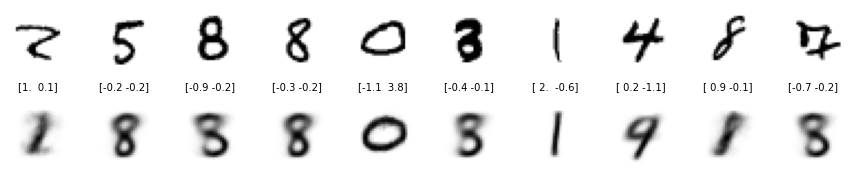

In [ ]:
n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')


#### 03 N.coder 画在墙上

从训练集中抽取5000个点，然后将这5000个点进行编码，之后 将编码结果进行打点展示

如下

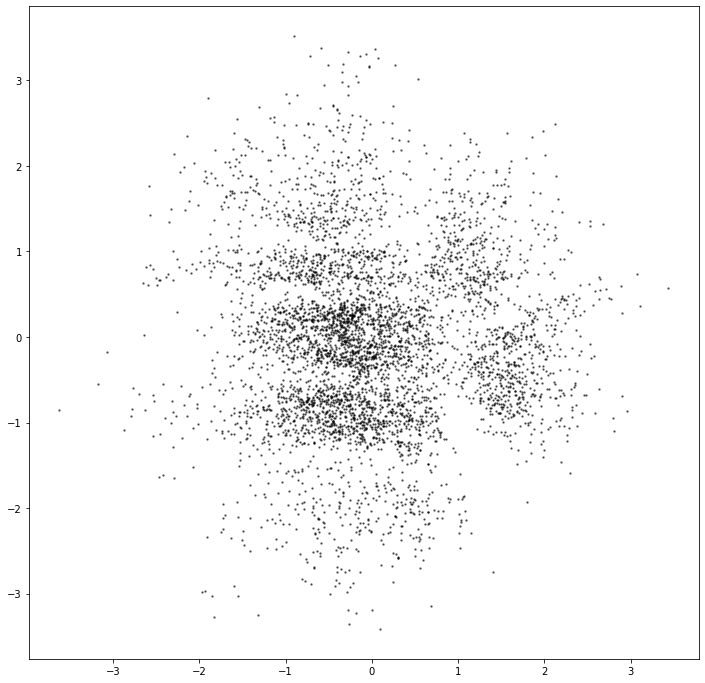

In [ ]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

将encoder的点通过散点图打出来。

在正态分布中随机抽取30个点，然后将这些点通过解码器解码之后得到的图片进行展示

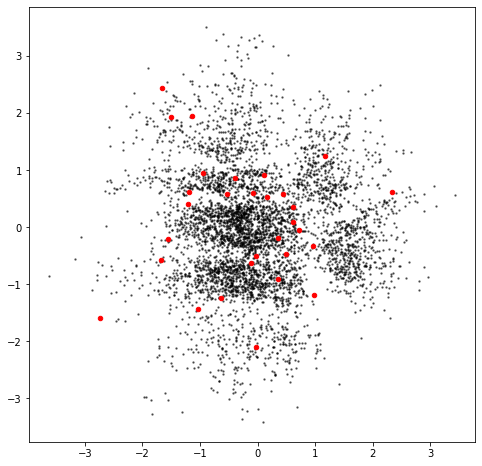

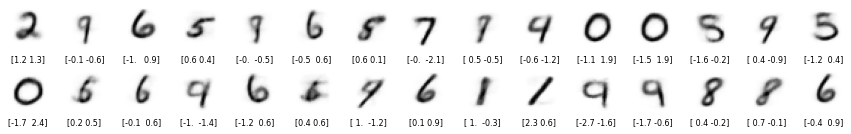

In [ ]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

In [ ]:
from scipy.stats import norm

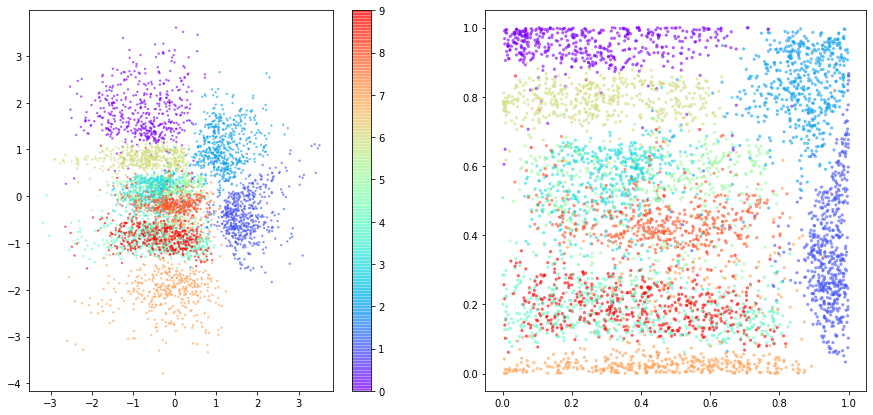

In [ ]:
n_to_show = 5000
grid_size = 15
fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)



plt.show()

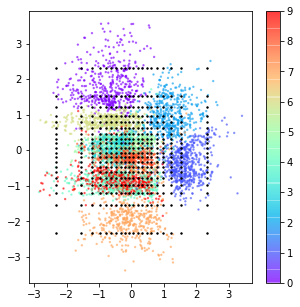

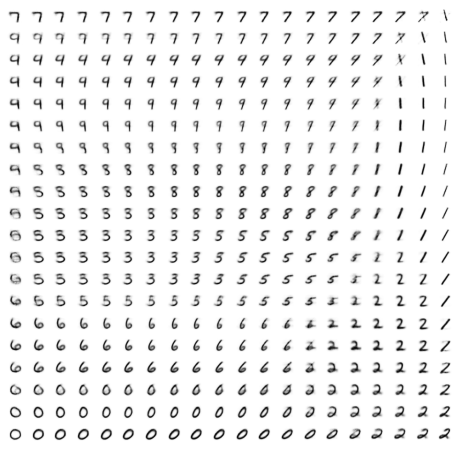

In [ ]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = vae.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=2)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

## vae 人脸实现
在人脸图片中实现vae编码解码，训练编码模型，实现人脸图片的生成和模糊等各种操作

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

### 01 定义训练过程的存储目录

In [ ]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = RUN_FOLDER = '/content/drive/MyDrive/google-tensorflow/generative_model/run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #




In [ ]:
DATA_FOLDER = '/content/celeba/img_align_celeba'

In [ ]:
!unzip  /content/drive/MyDrive/img_align_celeba.zip
# !ls /content/img_align_celeba

In [ ]:
!mkdir -p /content/celeba/img_align_celeba

In [ ]:
!mv /content/img_align_celeba /content/celeba/img_align_celeba/

In [ ]:
! rm -rf /content/celeba

In [ ]:
from glob import glob
import os
INPUT_DIM = (128,128,3)
BATCH_SIZE = 128

filenames = np.array(glob(os.path.join(DATA_FOLDER, '*.jpg')))

NUM_IMAGES = len(filenames)
NUM_IMAGES

0

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

target_size: 数元组(height,width)，默认：(256,256)。所有的图像将被调整到的尺寸



In [ ]:
# from keras_image
data_gen = ImageDataGenerator(rescale=1./255)
data_flow = data_gen.flow_from_directory(directory=DATA_FOLDER, target_size = INPUT_DIM[:2]
                                         , batch_size = 50000
                                         , shuffle = False
                                         , class_mode = 'input'
                                         , subset = "training")

Found 202599 images belonging to 1 classes.


In [ ]:
(next(data_flow)[0][0][0])

### 02 定义人脸vae  3通道

In [ ]:
vae = VariationalAutoencoder(
                input_dim = INPUT_DIM
                , encoder_conv_filters=[32,64,64, 64]
                , encoder_conv_kernel_size=[3,3,3,3]
                , encoder_conv_strides=[2,2,2,2]
                , decoder_conv_t_filters=[64,64,32,3]
                , decoder_conv_t_kernel_size=[3,3,3,3]
                , decoder_conv_t_strides=[2,2,2,2]
                , z_dim=200
                , use_batch_norm=True
                , use_dropout=True)

if mode == 'build':
    vae.save(RUN_FOLDER)
else:
    vae.load_weights(os.path.join(RUN_FOLDER, 'weights/weights.h5'))

In [ ]:
vae.encoder.summary()

In [ ]:
vae.encoder.summary()

In [ ]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 10000
EPOCHS = 10
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

### 03 训练

In [ ]:
vae.train(x_train= tmp, batch_size = BATCH_SIZE, epochs= 5 ,run_folder= RUN_FOLDER, initial_epoch=INITIAL_EPOCH)

参数 /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0001_faces
run.....
Train on 10000 samples
Epoch 1/5
10000/10000 [==============================] - ETA: 0s - loss: 353.9016 - vae_r_loss: 277.1314 - vae_kl_loss: 76.7701
Epoch 00001: saving model to /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0001_faces/weights/weights-001-353.90.h5

Epoch 00001: saving model to /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0001_faces/weights/weights.h5
10000/10000 [==============================] - 273s 27ms/sample - loss: 353.9016 - vae_r_loss: 277.1314 - vae_kl_loss: 76.7701
Epoch 2/5
10000/10000 [==============================] - ETA: 0s - loss: 316.3518 - vae_r_loss: 246.0448 - vae_kl_loss: 70.3071
Epoch 00002: saving model to /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0001_faces/weights/weights-002-316.35.h5

Epoch 00002: saving model to /content/drive/MyDrive/google-tensorflow/generative_model/run/vae/0001_faces/

In [ ]:
VAE = load_model(VariationalAutoencoder, RUN_FOLDER)

[(128, 128, 3), [32, 64, 64, 64], [3, 3, 3, 3], [2, 2, 2, 2], [64, 64, 32, 3], [3, 3, 3, 3], [2, 2, 2, 2], 200, True, True]


In [ ]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 10000

VAE.compile(LEARNING_RATE, R_LOSS_FACTOR)

### GPU bug
 TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.


 

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [ ]:
VAE.train(x_train= tmp, batch_size = BATCH_SIZE, epochs= 200 ,run_folder= RUN_FOLDER, initial_epoch=100)

NameError: ignored

In [ ]:
tmp= next(data_flow)[0]
tmp.shape

## vae分析

### 01 加载测试的数据

In [ ]:

class ImageLabelLoader():
  def __init__(self, image_folder, target_size):
    self.image_folder = image_folder
    self.target_size = target_size

  def build(self, att, batch_size, label = None):
    data_gen = ImageDataGenerator(rescale=1./255)
    if label:
      data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , y_col=label
                , target_size=self.target_size 
                , class_mode='other'
                , batch_size=batch_size
                , shuffle=True
      )
    else:
      data_flow = data_gen.flow_from_dataframe(
                att
                , self.image_folder
                , x_col='image_id'
                , target_size=self.target_size 
                , class_mode='input'
                , batch_size=batch_size
                , shuffle=True
            )

    return data_flow

In [ ]:
import pandas as pd

In [ ]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join('/content', 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader("/content/celeba/img_align_celeba/img_align_celeba", INPUT_DIM[:2])


In [ ]:
att.head()

image_id  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  000001.jpg                -1  ...               -1      1
1  000002.jpg                -1  ...               -1      1
2  000003.jpg                -1  ...               -1      1
3  000004.jpg                -1  ...               -1      1
4  000005.jpg                -1  ...               -1      1

[5 rows x 41 columns]

### 02  画出原图和预测的结果图

Found 202599 validated image filenames.


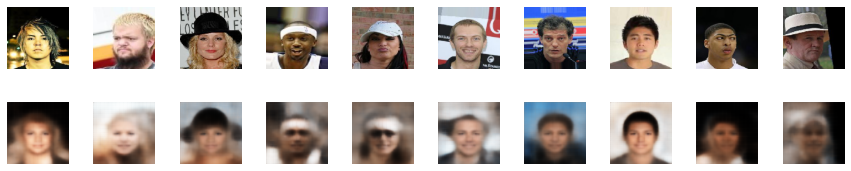

In [ ]:
n_to_show = 10

data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]

z_points = VAE.encoder.predict(example_images)

reconst_images = VAE.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img)


### 03 潜在状态空间分布

基本上都属于正态分布

In [ ]:
from scipy.stats import norm

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


20/20 [==============================] - 1s 30ms/step


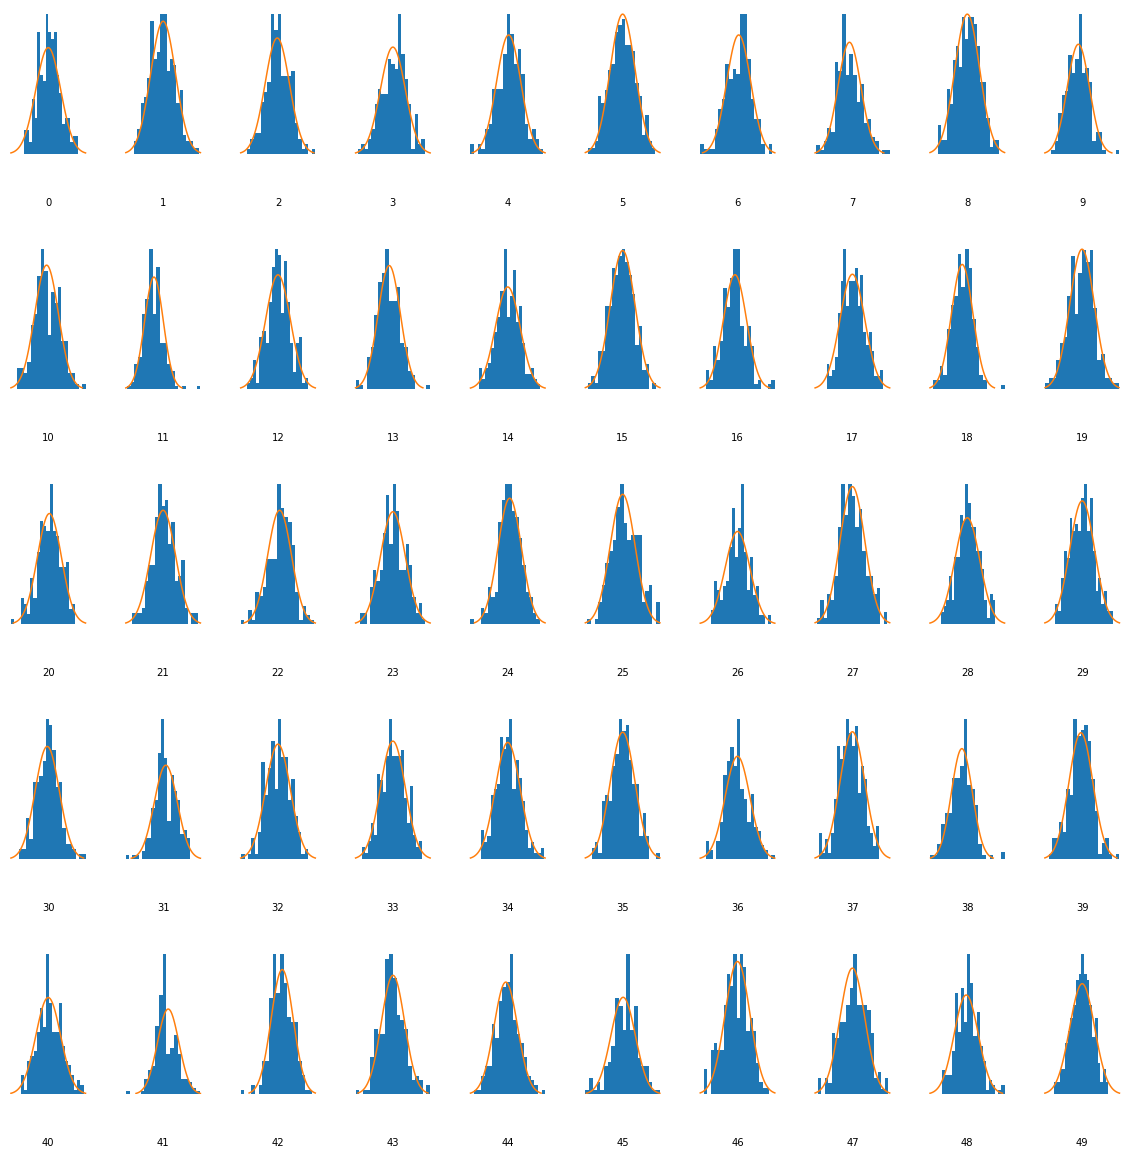

In [ ]:
z_test = VAE.encoder.predict_generator(data_flow_generic, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

### 04 随机生成点，根据点画图

令人惊讶的是，VAE能够将我们采样的点集合转换成令人信服的人脸图像。虽然这些图像并不完美，但它们是我们在第一章开始探索的朴素贝叶斯模型的一个巨大飞跃。朴素贝叶斯模型面临的问题是不能捕获相邻像素之间的依赖关系，因为它没有太阳镜或棕色头发等高级特征的概念。VAE没有这个问题，因为编码器的卷积层被设计成将低级像素转换成高级像素

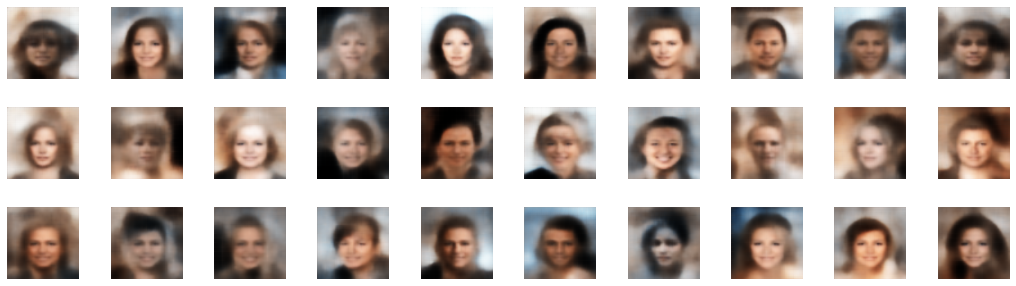

In [ ]:
n_to_show = 30

znew = np.random.normal(size = (n_to_show,VAE.z_dim))

reconst = VAE.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(3, 10, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()

### 05 维度分析
将图像映射到低维空间的一个好处是，我们可以对这个潜在空间中的向量进行算术运算，当解码回到原始图像域时，这个潜在空间具有视觉模拟


例如，假设我们想给一个看起来很悲伤的人拍一张照片，然后给他们一个微笑。要做到这一点，我们首先需要在潜在空间中找到一个指向增加微笑的方向的向量。在潜在空间中将这个向量添加到原始图像的编码中，将给我们一个新的点，当解码时，应该给我们一个更微笑的原始图像版本。

那么我们如何找到微笑向量呢?CelebA数据集中的每个图像都标有属性，其中一个是微笑的。如果取具有微笑属性的编码图像在潜在空间中的平均位置，减去不具有微笑属性的编码图像的平均位置，就得到了从不微笑指向微笑的向量，这正是我们所需要的。

从概念上讲，我们在潜在空间中执行以下向量算法，其中alpha是一个决定特征向量加多少或减多少的因子:




    具有微笑属性的向量  
	    平均值
    不具有微笑属性的向量
	    平均值


    正向量-负向量

In [ ]:
data_flow_label = imageLoader.build(att,500,'Attractive')
image_label = next(data_flow_label)

Found 202599 validated image filenames.


In [ ]:
attribute= image_label[1]
z= VAE.encoder.predict(np.array(image_label[0]))
z_TEST = z[attribute==1]
z_TEST

array([[-1.043305  ,  0.9189758 , -0.46862558, ...,  0.30648804,
         1.3699126 ,  1.836195  ],
       [-0.18067381, -0.8475057 , -2.3423867 , ...,  0.6152551 ,
        -0.18316577, -1.0243236 ],
       [-1.4439106 , -1.1537054 , -0.46046782, ..., -0.33391047,
         1.5746765 ,  1.4916798 ],
       ...,
       [-2.080552  , -1.460844  ,  0.02317296, ..., -0.56207395,
        -0.9504697 , -1.8873315 ],
       [ 1.6170871 ,  1.4636469 , -0.01181477, ..., -0.9607099 ,
        -0.3826498 , -0.857984  ],
       [-0.19344273,  0.32084462, -0.5848637 , ..., -0.13034831,
        -0.13798094,  0.69394225]], dtype=float32)

In [ ]:
z_TEST.shape

(245, 200)

In [ ]:
attribute[attribute==1].sum()

245

In [ ]:
z.shape

(500, 200)

In [ ]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = VAE.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = VAE.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = VAE.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = VAE.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = VAE.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = VAE.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = VAE.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   


In [ ]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = VAE.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = VAE.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()


In [ ]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

Found 202599 validated image filenames.
label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
257    : 1.135    : 0.937    : 1.582    : 1.582
509    : 0.638    : 0.6    : 1.237    : -0.345
753    : 0.349    : 0.419    : 1.17    : -0.067
1008    : 0.26    : 0.265    : 1.129    : -0.041
1249    : 0.19    : 0.196    : 1.1    : -0.029
1498    : 0.165    : 0.16    : 1.044    : -0.056
1741    : 0.124    : 0.127    : 1.047    : 0.003
2008    : 0.123    : 0.108    : 1.056    : 0.009
2246    : 0.099    : 0.101    : 1.062    : 0.006
2511    : 0.089    : 0.095    : 1.049    : -0.013
2782    : 0.084    : 0.08    : 1.039    : -0.01
3038    : 0.084    : 0.079    : 1.038    : -0.001
3303    : 0.077    : 0.074    : 1.024    : -0.014
3579    : 0.069    : 0.067    : 1.031    : 0.007
3846    : 0.066    : 0.056    : 1.029    : -0.002
4111    : 0.058    : 0.053    : 1.03    : 0.001
4369    : 0.058    : 0.052    : 1.032    : 0.002
4624    : 0.052    : 0.051    : 1.041    : 0.009
4869    : 0.

In [ ]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 validated image filenames.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
33    : 2.74    : 0.729    : 2.804    : 2.804
63    : 1.782    : 0.476    : 2.163    : -0.641
95    : 1.049    : 0.249    : 1.873    : -0.289
130    : 0.754    : 0.182    : 1.729    : -0.145
153    : 0.475    : 0.14    : 1.677    : -0.052
184    : 0.473    : 0.104    : 1.647    : -0.03
214    : 0.404    : 0.098    : 1.654    : 0.007
254    : 0.387    : 0.087    : 1.654    : 0.0
289    : 0.329    : 0.083    : 1.654    : -0.0
319    : 0.259    : 0.069    : 1.646    : -0.009
348    : 0.262    : 0.062    : 1.62    : -0.026
376    : 0.177    : 0.057    : 1.604    : -0.016
406    : 0.2    : 0.055    : 1.597    : -0.007
439    : 0.192    : 0.046    : 1.59    : -0.007
469    : 0.155    : 0.042    : 1.577    : -0.013
507    : 0.176    : 0.044    : 1.575    : -0.002
538    : 0.145    : 0.041    : 1.58    : 0.005
566    : 0.136    : 0.035    : 1.583    : 0.003
603    : 0.148    : 0.034   

给所有图片增加Eyeglass维度

Eyeglasses Vector


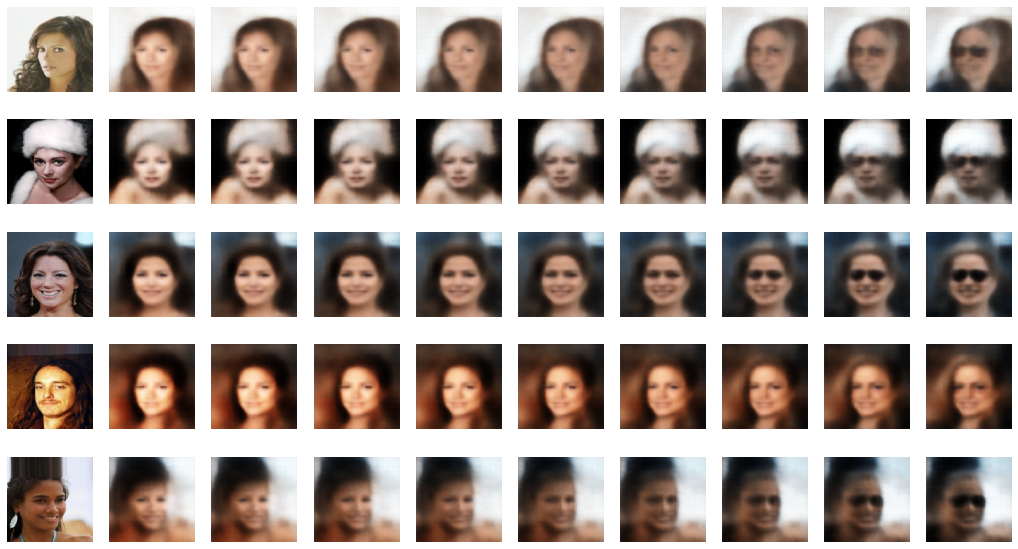

In [ ]:
print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blond Vector')
# add_vector_to_images(blonde_vec)

Blond Vector


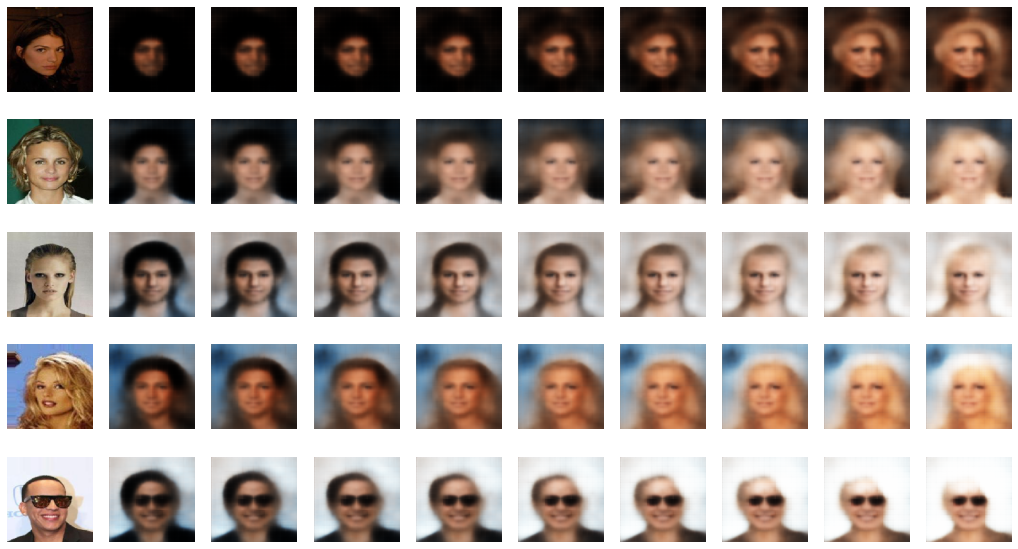

In [ ]:
print('Blond Vector')
add_vector_to_images(blonde_vec)

Smiling Vector


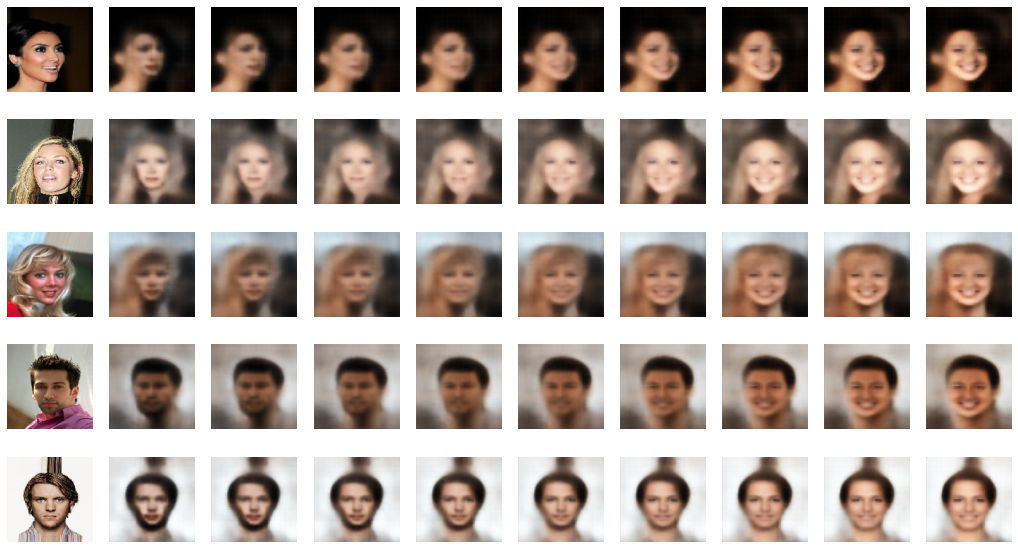

In [ ]:
print('Smiling Vector')
add_vector_to_images(smiling_vec)

值得注意的是，即使我们将点在潜在空间中移动很大的距离，核心图像几乎没有变化，除了我们想要处理的一个特征。这说明了可变自动编码器在捕捉和调整图像高级特征方面的强大功能

### 06 变形的脸

我们可以使用类似的想法在两个面之间变形。想象潜伏空间中的两个点，A和B，它们代表两幅图像。如果你从A点开始，沿直线向B点移动，并在移动过程中解码直线上的每个点，你会看到从起点到终点的渐变。

在数学上，我们走过一条直线，这条直线可以用下面的方程来描述:

z_new = z_A * (1-alpha) + z_B * alpha



In [ ]:

def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = VAE.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = VAE.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 validated image filenames.


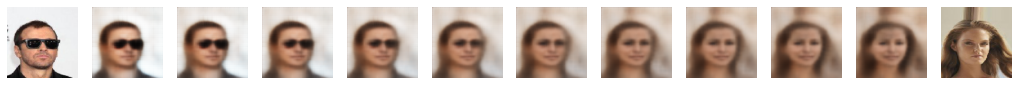

In [ ]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


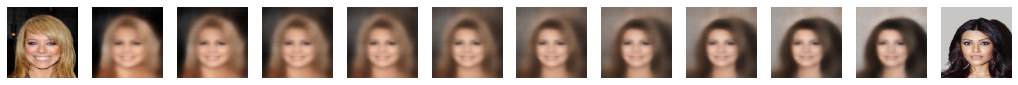

In [ ]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


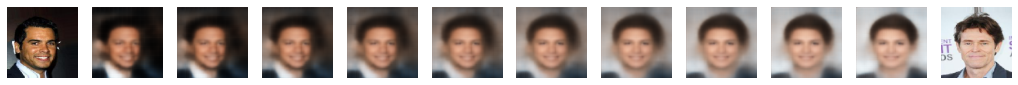

In [ ]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)

值得注意的是转换的平滑性——即使同时改变多个特征(例如摘掉眼镜、头发颜色、性别)，VAE也能流畅地实现这一点，表明VAE的潜在空间确实是一个可以穿越和探索的连续空间，以生成多种不同的人脸.

## Done